## Sztuczne sieci neuronowe - laboratorium 2

### Poszukiwanie parametrów modelu

#### Dane studenta: Natalia Chostenko, 118764

In [1]:
import torch

Załóżmy, że mamy dwa termometry:
- jeden mierzy temperaturę w stopniach Celsjusza
- drugi mierzy temperaturę w nieznanej nam skali, ale jest bardzo ładny i chcemy go powiesić na ścianie

Zanim to zrobimy, chcemy się dowiedzieć, jak przeliczać wskazania drugiego termometru na stopnie Celsjusza.
Spróbujemy znaleźć "wzór" tego przekształcenia na podstawie pomiarów dokonanych obydwoma termometrami.

In [2]:
data_celsius = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
data_unknown = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

#### Ćwiczenie
Zwizualizuj dane pomiarowe jako punkty na płaszczyźnie (użyj `plt.scatter()`), na osi poziomej umieszczając temperaturę w nieznanej skali, a na osi pionowej - temperaturę w stopniach Celsjusza.

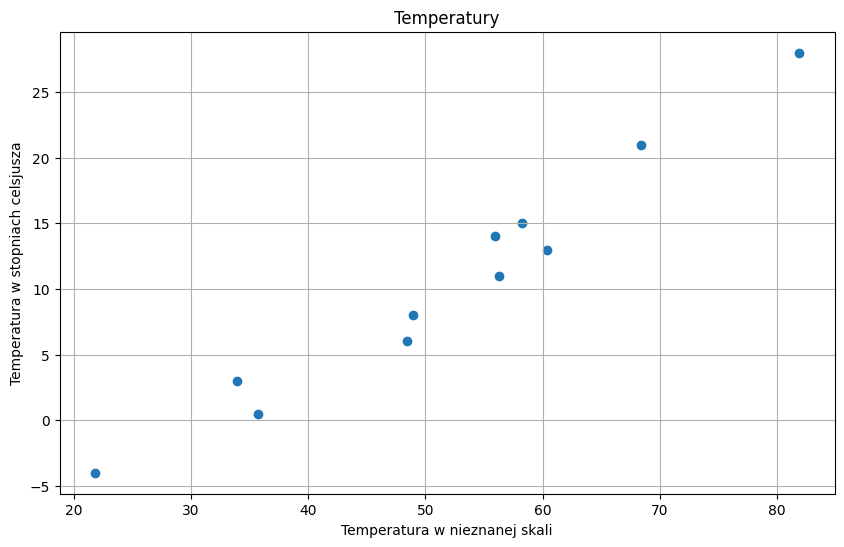

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(data_unknown, data_celsius)
plt.title('Temperatury')
plt.xlabel('Temperatura w nieznanej skali')
plt.ylabel('Temperatura w stopniach celsjusza')
plt.grid(True)
plt.show()


#### Ćwiczenie
Stwórz tensory `t_c` (temp. w stopniach Celsjusza) i `t_u` (temp. w skali "unknown") na podstawie danych.

In [27]:
# konwersja list do tensorów 
t_c = torch.tensor(data_celsius)
t_u = torch.tensor(data_unknown)

print("Temperatura t_c ", t_c)
print("Temperatura t_u ", t_u)


Temperatura t_c  tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000])
Temperatura t_u  tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


#### Ćwiczenie
Zaproponuj na podstawie powyższej wizualizacji danych, jakiego modelu (możliwie prostego) użyć w tym zagadnieniu.
Podaj "wzór" modelu i zdefiniuj funkcję `model(t_u, ...)` przekształcającą tensor wejściowy `t_u` w predykcję (niech funkcja zwróci tensor). Jakie będą parametry tego modelu?

Na podstawie wizualizacji danych widac że relacja między temperatura w nieznanej skali  a 
temperatura w stopniach celsjusza jest liniowa wiec najprostszym modelem bedzie model liniowy. 
Wzór na model liniowy:
t_c = a * t_u + b

funkcja model:
def model(t_u, a, b):
    return a * t_u + b
    
Parametry modelu a i b: a - waga a b - intercept czyli przesuniecie, trzeba je obliczyc

In [38]:
def model(t_u, a, b):
    return a * t_u + b
t_p = model(t_u, 1,0) #poczatkowe wartosci parametrow
print(t_p)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


#### Ćwiczenie
Wybierz funkcję straty typową dla zadania regresji i zaimplementuj ją jako funkcję `loss_fn()`. Niech przyjmuje dwa argumenty - tensor predykcji `t_p` oraz tensor prawdziwych wartości `t_c`. Niech funkcja zwraca wartość funkcji straty (skalar / liczbę).

In [39]:
# definicja MSE
def loss_fn(t_p, t_c):
    error_squares = (t_p - t_c)**2
    return error_squares.mean()

# obliczenie MSE
loss = loss_fn(t_p, t_c)

print("Wartość funkcji straty ", loss)


Wartość funkcji straty  tensor(1763.8848)


#### Ćwiczenie
Zainicjalizuj parametry modelu jako tensory "zero-wymiarowe" (skalary) `w` i `b` o wartościach odpowiednio 1 i 0.
Wykorzystaj w tym celu `torch.zeros()` i `torch.ones()` podając jako argument: `()`

Oblicz tensor predykcji modelu dla zadanych parametrów oraz wartość funkcji straty używając zaimplementowanych wyżej funkcji.

In [65]:
w = torch.ones(())
b = torch.zeros(())

#  definicja modelu (zamieniam a z poprzedniego zadania na w zgodne z poleceniem)
def model(t_u, w, b):
    return w * t_u + b

# obliczenie tensora predykcji 
t_p = model(t_u, w, b)

print("Tensor predykcji to", t_p)

Tensor predykcji to tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


### Badanie wpływu parametrów na wartość funkcji straty

Powyżej obliczyliśmy wartość funkcji straty przy określonym zestawie parametrów modelu. Sprawdźmy teraz, co się stanie, gdy każdy z tych parametrów (niezależnie od siebie) zwiększymy lub zmniejszymy o pewną wartość `delta`. Pozwoli to oszacować współczynniki zmiany wartości funkcji straty przy zmianie wartości parametru (dla każdego z parametrów z osobna).

Na podstawie tych współczynników, będziemy próbowali następnie zmienić wartości parametrów w taki sposób (zmniejszyć lub zwiększyć), aby  "podążać w kierunku" malejącej funkcji straty. Jeśli współczynnik dla danego parametru wyjdzie ujemny, to znaczy, że zwiększenie tego parametru zmniejsza funkcję straty, a zatem ten parametr należy jeszcze zwiększyć. Analogicznie, gdy współczynnik jest dodatni, zmniejszamy wartość tego parametru.

Należy jednak uważać, aby pojedyncza zmiana parametru nie była ani zbyt mała, ani zbyt duża. Wielkość "kroku" kontroluje się typowo stosując tzw. stałą uczącą (ang. `learning_rate`). Stała ucząca jest jednym z najważniejszych hiperparametrów modeli (np. sieci neuronowych).

#### Ćwiczenie

Uzupełnij poniższy kod i oblicz współczynniki zmiany wartości funkcji straty ze względu na poszczególne parametry modelu. Przyjmuj `delta` = 0.1

In [67]:
delta = 0.1

# ZASTĄP WYSTĄPIENIA SŁOWA "None" WŁASNYM KODEM

loss_w_plus_delta = loss_fn(model(t_u, w + delta, b), t_c)
loss_w_minus_delta = loss_fn(model(t_u, w - delta, b), t_c)

loss_b_plus_delta = loss_fn(model(t_u, w, b + delta), t_c)
loss_b_minus_delta = loss_fn(model(t_u, w, b - delta), t_c)

loss_rate_of_change_w = (loss_w_plus_delta - loss_w_minus_delta) / (2*delta)

loss_rate_of_change_b = (loss_b_plus_delta - loss_b_minus_delta) / (2*delta)

print(loss_rate_of_change_w.item())
print(loss_rate_of_change_b.item())



4517.29736328125
82.5994873046875


#### Ćwiczenie
Zaktualizuj (nadpisz) wartości parametrów odejmując od poprzedniej wartości współczynnik zmiany funkcji straty przemnożony przez tzw. `learning_rate` - stałą uczącą. Niech `learning_rate` wynosi 0.01.

In [31]:
learning_rate = 0.01

w = w - learning_rate * loss_rate_of_change_w
b = b - learning_rate * loss_rate_of_change_b

print(w)
print(b)


tensor(-44.1730)
tensor(-0.8260)


### Pochodna funkcji

Pochodna funkcji jest miarą szybkości zmian wartości funkcji względem zmian jej argumentów. Obliczając pochodną funkcji w punkcie, liczymy w zasadzie współczynnik jak wyżej, przyjmując nieskończenie małe `delta`. Interesuje nas pochodna funkcji straty względem poszczególnych parametrów modelu - gradient.

Do obliczania pochodnych funkcji złożonych wykorzystuje się tzw. regułę łańcuchową ("chain rule").

Funkcja straty `L` jest funkcją predykcji modelu `t_p`. `t_p` zależy od parametrów modelu (`w` i `b`).
Pochodna funkcji straty ze względu na parametr `w` może być obliczona następująco:

`dL/dw = (dL/dtp) * (dtp/dw)`

Analogicznie dla parametru `b`:

`dL/db = (dL/dtp) * (dtp/db)`

#### Ćwiczenie

Wykorzystaj swoją wiedzę z analizy matematycznej, aby napisać funkcję `dloss_fn` obliczającą pochodną funkcji straty względem predykcji (na podstawie zaimplementowanej wcześniej `loss_fn` - błędu średniokwadratowego). Będzie to człon `dL/dtp` w powyższym wzorze.

Tymczasowo pomiń we wzorze obliczanie średniej - zrobimy to w odpowiednim miejscu.

In [45]:
def dloss_fn(t_p, t_c):
    return -2 * (t_c - t_p)
dloss = dloss_fn(t_p, t_c)
print(dloss)
#-2 bo poruszamy sie w przeciwnym kierunku do gradientu

tensor([ 70.4000,  83.8000,  86.4000, 107.8000,  90.6000,  81.8000,  61.8000,
         51.6000,  84.8000,  94.8000,  94.8000])


#### Ćwiczenie
Napisz funkcje `dmodel_dw()` oraz `dmodel_db()` przyjmujące jako argumenty: tensor wejściowy `t_u` i parametry modelu (`w` i `b`), a zwracające pochodne predykcji modelu względem parametrów (drugi człon z chain rule, odpowiednio `dtp/dw` i `dtp/db`).


In [54]:
def dmodel_dw(t_u, w, b):
    return t_u
#pochodna funkcji liniowej względem w jest wartoscia tensora wejsciowego (d_tp / d_w = t_u)
print(dmodel_dw(t_u,w,b))



tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


In [55]:
def dmodel_db(t_u, w, b):
    return 1
#pochodna funkcji liniowej wzgledem b to zawsze 1
print(dmodel_db(t_u,w,b))

1


#### Ćwiczenie
Uzupełnij poniższy kod, aby obliczyć gradient funkcji straty, czyli wektor (tensor) pochodnych względem parametrów modelu).

Zwróć uwagę na użycie funkcji `mean()` w zwracanym tensorze.

In [53]:
# ZASTĄP WYSTĄPIENIA SŁOWA "None" WŁASNYM KODEM

def grad_fn(t_u, t_c, t_p, w, b):
    dL_dtp = dloss_fn(t_p, t_c)  # pochodna funkcji straty wzgledem predykcji
    dL_dw = dL_dtp * t_u  # regula lancuchowa dla w
    dL_db = dL_dtp * 1  # regula lancuchowa dla b
    return torch.stack([dL_dw.mean(), dL_db.mean()])
gradient = grad_fn(t_u, t_c, t_p, w, b)
print(gradient)


tensor([4517.2964,   82.6000])


### Algorytm najszybszego spadku

Gradient (jako wektor pochodnych cząstkowych) wskazuje (wielowymiarowy) kierunek najszybszego wzrostu funkcji.

Algorytm najszybszego spadku (ang. gradient descent) jest iteracyjnym algorytmem optymalizacji funkcji (straty), w którym w każdej iteracji aktualizujemy parametry "podążając" w kierunku przeciwnym do gradientu (wektor o przeciwnym zwrocie) - a więc w kierunku najszybszego spadku.

Jest on realizowany przez poniższy kod.

In [56]:
def training_loop(n_iters, learning_rate, params, t_u, t_c):
    for iteration in range(1, n_iters+1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        # tzw. "vanilla" gradient descent
        params = params - learning_rate * grad

    print('After iteration %d, Loss %f' % (iteration, float(loss)))

    return params

#### Ćwiczenie
Uruchom funkcję `training_loop` dla 100 iteracji, przy `learning_rate` równym 0.01, inicjalizując parametry `w` i `b` wartościami 1.0 i 0.0.

Zaobserwuj, co się stało, i pomyśl, dlaczego. Co się stało i dlaczego?

In [17]:
# TU WPISZ WŁASNY KOD

n_iters = 100
learning_rate = 0.01
params = torch.tensor([1.0, 0.0], requires_grad=True)  # inicjalizacja w i b

trained_params = training_loop(n_iters, learning_rate, params, t_u, t_c) #uruchomienie


After iteration 100, Loss nan


 po próbie zmiany liczby interacji na mniejsza (np. 20) , funkcja straty wyswietlila sie w poprawnym formacie, przy 100 algorytm nie dziala poprawnie
prawdopodobnie z powodu tego ze krok jest za duzy i minimum funkcji zostaje przeskoczone.

#### Ćwiczenie
Uruchom `training_loop` dla 100 iteracji zmniejszając `learning_rate` do 0.0001. Co się zmieniło?

In [18]:
# TU WPISZ WŁASNY KOD

n_iters = 100
learning_rate = 0.0001
params = torch.tensor([1.0, 0.0], requires_grad=True)  # inicjalizacja w i b

trained_params = training_loop(n_iters, learning_rate, params, t_u, t_c) #uruchomienie

After iteration 100, Loss 29.137590


funkcja straty zwiększyła sie, prawdopodobnie bardziej zblizylismy się do minimum, bo kroki są mniejsze.

### Normalizacja danych

Poza `learning_rate`, we wzorze na aktualizację parametrów modelu występuje także gradient. Przyjrzyjmy się zawartości zmiennej `grad` w kolejnych iteracjach.

Widzimy, że w początkowych iteracjach treningu gradient dla parametru `w` jest znacząco większy (ok. 50 razy) niż dla `b`. Wskazuje to na fakt, że parametry nie są w tej samej skali i trudno dobrać do nich ten sam `learning_rate`.

Uwaga:
Bardziej złożone algorytmy optymalizacji radzą sobie częściowo z tym problemem - wrócimy do tego na kolejnych zajęciach.

In [48]:
def training_loop_print_grad(n_iters, learning_rate, params, t_u, t_c):
    for iteration in range(1, n_iters+1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        print(grad)
        # tzw. "vanilla" gradient descent
        params = params - learning_rate * grad

    print('After iteration %d, Loss %f' % (iteration, float(loss)))

    return params

In [49]:
training_loop_print_grad(n_iters = 100,
              learning_rate = 1e-4,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_u,
              t_c = t_c)

tensor([4517.2964,   82.6000])
tensor([1859.5492,   35.7843])
tensor([765.4666,  16.5122])
tensor([315.0790,   8.5787])
tensor([129.6733,   5.3127])
tensor([53.3496,  3.9682])
tensor([21.9304,  3.4148])
tensor([8.9965, 3.1869])
tensor([3.6721, 3.0930])
tensor([1.4803, 3.0544])
tensor([0.5781, 3.0384])
tensor([0.2066, 3.0318])
tensor([0.0537, 3.0291])
tensor([-0.0093,  3.0279])
tensor([-0.0352,  3.0274])
tensor([-0.0459,  3.0272])
tensor([-0.0502,  3.0270])
tensor([-0.0520,  3.0270])
tensor([-0.0528,  3.0269])
tensor([-0.0531,  3.0268])
tensor([-0.0532,  3.0268])
tensor([-0.0533,  3.0267])
tensor([-0.0533,  3.0267])
tensor([-0.0533,  3.0266])
tensor([-0.0533,  3.0266])
tensor([-0.0533,  3.0265])
tensor([-0.0533,  3.0265])
tensor([-0.0532,  3.0264])
tensor([-0.0533,  3.0264])
tensor([-0.0533,  3.0263])
tensor([-0.0532,  3.0262])
tensor([-0.0533,  3.0262])
tensor([-0.0533,  3.0261])
tensor([-0.0533,  3.0261])
tensor([-0.0532,  3.0260])
tensor([-0.0533,  3.0260])
tensor([-0.0533,  3.0259])

tensor([ 0.2327, -0.0438])

Rozwiązaniem problemu może być odpowiednia normalizacja wejść do modelu. Temat ten będzie szerzej omawiany w późniejszym czasie, na teraz spróbujmy jedynie przeskalować wejścia zmniejszając je 10-krotnie (`t_u * 0.1`) . Teraz model nie "wybuchnie" nawet dla `learning_rate` równego 0.01.

In [22]:
training_loop_print_grad(n_iters = 100,
              learning_rate = 1e-2,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_u * 0.1,
              t_c = t_c)

tensor([-7.0558, -0.9673])
tensor([-6.6694, -0.8991])
tensor([-6.3044, -0.8346])
tensor([-5.9594, -0.7737])
tensor([-5.6335, -0.7162])
tensor([-5.3255, -0.6618])
tensor([-5.0345, -0.6105])
tensor([-4.7596, -0.5619])
tensor([-4.4998, -0.5161])
tensor([-4.2544, -0.4728])
tensor([-4.0224, -0.4318])
tensor([-3.8033, -0.3932])
tensor([-3.5962, -0.3566])
tensor([-3.4006, -0.3221])
tensor([-3.2157, -0.2895])
tensor([-3.0410, -0.2587])
tensor([-2.8760, -0.2296])
tensor([-2.7201, -0.2021])
tensor([-2.5727, -0.1761])
tensor([-2.4335, -0.1515])
tensor([-2.3020, -0.1284])
tensor([-2.1777, -0.1064])
tensor([-2.0602, -0.0857])
tensor([-1.9493, -0.0662])
tensor([-1.8444, -0.0477])
tensor([-1.7453, -0.0302])
tensor([-1.6517, -0.0137])
tensor([-1.5633,  0.0018])
tensor([-1.4797,  0.0166])
tensor([-1.4008,  0.0305])
tensor([-1.3261,  0.0436])
tensor([-1.2557,  0.0560])
tensor([-1.1890,  0.0677])
tensor([-1.1261,  0.0788])
tensor([-1.0666,  0.0893])
tensor([-1.0104,  0.0992])
tensor([-0.9573,  0.1085])
t

tensor([ 2.3142, -0.0449])

#### Ćwiczenie

Uruchom `training_loop` (nie ma potrzeby wypisywania gradientów) dla większej liczby iteracji - sparwdź np. 1000, 2000, 5000, 10000. Niech `learning_rate` wynosi 0.01. Pamiętaj o przeskalowaniu wejść do modelu (`t_u * 0.1`).

Przypisz wartości parametrów (zwracane przez funkcję) do zmiennej `params`.

In [63]:
# TU WPISZ WŁASNY KOD

# przeskalowanie
t_u_scaled = t_u * 0.1

# rozna liczba iteracji
params = training_loop(n_iters=1000, learning_rate=0.01, params=torch.tensor([1.0, 0.0]), t_u=t_u_scaled, t_c=t_c) #trzeba zainicjowac parametry

params = training_loop(n_iters=2000, learning_rate=0.01, params=params, t_u=t_u_scaled, t_c=t_c)

params = training_loop(n_iters=5000, learning_rate=0.01, params=params, t_u=t_u_scaled, t_c=t_c)

params = training_loop(n_iters=10000, learning_rate=0.01, params=params, t_u=t_u_scaled, t_c=t_c)



After iteration 1000, Loss 3.828538
After iteration 2000, Loss 2.928648
After iteration 5000, Loss 2.927645
After iteration 10000, Loss 2.927645


#### Ćwiczenie

Uruchom poniższy kod, aby zwizualizować dopasowanie modelu do danych (przy znalezionych parametrach).

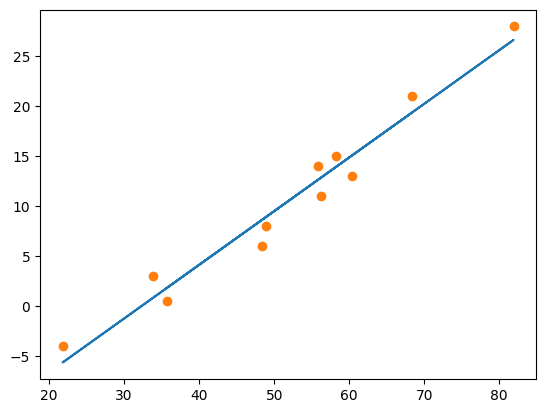

In [64]:
import matplotlib.pyplot as plt

t_p = model(t_u * 0.1, *params)

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

#### Ćwiczenie
1. Jaki będzie ostatecznie "wzór" przeliczający skalę "unknown" na stopnie Celsjusza?
2. Czy wiesz, jaka skala kryje się pod "unknown"?  
3. Dla jakiej temperatury wartość na obu skalach będzie taka sama?

1) wzor t_c=a⋅t_u+b gdzie a to gradient a b to intercept czyli wg wzoru na model liniowy, wspolczynniki a i b muszą zostac obliczone np. metoda najmniejszych kwadratow i wychodzi a=0.537 i b=−17.305

2) najprawdopodobniej skala Fahrenheita albo jakas wariacja, bo wzór jest podobny
   
3) t_u = -b/(a-1) = −37.36 po przeksztalceniu wzoru wyzej czyli okolo 40, co sie w miare zgadza ze skala Fahrenheita

#### Wnioski: 
*zbyt duze tempo uczenia sprawia ze model przeskoczy minimum funkcji straty a zbyt małe spowalnia proces uczenia

*Na podstawie obliczonych współczynników zmiany można zdecydować, w którym kierunku należy zmodyfikować parametry by zmniejszyc funkcje straty. Jeśli współczynnik zmiany dla danego parametru jest dodatni to zwiekszenie wartości tego parametru zwiększy wartość funkcji straty, czyli zmniejszamy wartosc parametru, analogicznie do ujemnego

* reguła łancuchowa to przydatne narzędzie to rozkładania procesu różniczkowania na prostsze kroki w przypadku gdy mamy np. zlozenie wielu funkcji (np. straty)

